In [ ]:
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
np.random.seed(1234)
grids = 15
data = np.zeros((grids,grids))
data[:,0] = 1
data[:,grids-1] = 1
data[0,:] = 1
data[grids-1,:] = 1

ratio = 0.40
for i in range(2,grids-2,1):
  for j in range(1,grids-1,1):
    if np.random.rand() <= ratio:
      data[i,j] = 2
data[8, 9] =  2
data[3,13] =  2
data[9,10] =  2
data[9,11] =  2

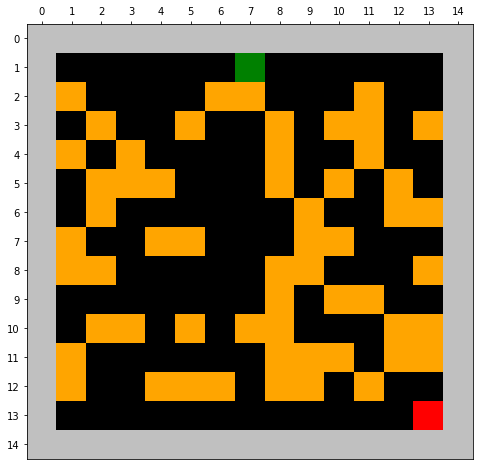

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import colors

startx,starty = grids-2,grids-2
data[startx,starty] = 3 #starting point
goal_y = int(np.random.rand() * (grids-3)) 
data[1,goal_y+1] = 4 #destination
'''
#0:normal 1:wall 2:obstacle 3:starting point 4:destination
'''
cmap = colors.ListedColormap(['black','silver','orange','red','green'])
fig,ax = plt.subplots(1,figsize=(8,8))
plt.pcolor(data[::-1],cmap=cmap, linewidths=1)
plt.xticks(np.arange(0.5,grids+0.5,step=1))
plt.yticks(np.arange(0.5,grids+0.5,step=1))
xlabels = ['14','13','12','11','10','9','8','7','6','5','4','3','2','1','0']
ylabels = ['14','13','12','11','10','9','8','7','6','5','4','3','2','1','0']
#ylabels = ['4','3','2','1','0']
ax.set_yticklabels(ylabels)
ax.set_xticklabels(xlabels[::-1])
ax.xaxis.tick_top()
#plt.scatter(1, 24, s=500,c='b', marker=(5, 1))
#plt.scatter(0.5, 4.5, s=500,c='r', marker=(5, 1))
plt.show()



In [ ]:
actions_space = ['U','D','L','R']
from numpy import linalg as LA
        
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

class  GridWorld():
    def __init__(self,K,reward_b = 0.1,cost_b=0.1):
        self.current_location = [startx,starty]
        self.max_distance = LA.norm(np.array([18,1]) - np.array([1,goal_y+1]))
        self.delta = 0.05 
        self.reward_change = np.random.randint(2, size= (grids,grids)) * 2 - 1
        self.variation_r = np.zeros((grids,grids))
        self.variation_c = 0
        self.K = K
        self.reward_b = reward_b
        self.cost_b = cost_b
        self.action_space = ['U','D','L','R']
        
    def variation(self):
        self.variation_r += self.reward_change * self.reward_b / self.K
        self.variation_c += self.cost_b / self.K
        self.delta += 0.1 / self.K

    def reset_location(self):
        self.current_location = [startx,starty]
        
    def get_reward(self, location):
        """Returns the reward for an input position"""
        norm_r = LA.norm(np.array(location) - np.array([1,goal_y+1]))
        if data[location[0],location[1]] == 4:
            r = 1
        else:
            r = max( ((self.max_distance - norm_r) / self.max_distance) * 0.1 + self.variation_r[location[0],location[1]],0)
        return r

    def check_border(self,location):
        if location[0] <= 0 or location[0] >= grids-1 :
            return 1
        elif location[1] <= 0 or location[1] >= grids-1:
            return 1
        else:
            return 0
        
    def make_step(self, action):
        # Store previous location
        last_location = self.current_location
        if np.random.rand() <= self.delta:
            action = self.action_space[np.random.choice(4,1)[0]]
        # UP
        if action == 'U':
            border_ = self.check_border([last_location[0]-1, last_location[1]])
            if border_ == 1:
                reward = self.get_reward(last_location) 
            else:
                reward = self.get_reward([last_location[0] - 1, last_location[1]]) 
                self.current_location = [last_location[0] - 1, last_location[1]]             
        # DOWN
        elif action == 'D':
            border_ = self.check_border([last_location[0] + 1, last_location[1]])
            if border_ == 1:
                reward = self.get_reward(last_location)
            else:
                reward = self.get_reward([last_location[0] + 1, last_location[1]]) 
                self.current_location = [last_location[0] + 1, last_location[1]]

        elif action == 'L':
            border_ = self.check_border([last_location[0], last_location[1] - 1])
            if border_ == 1:
                reward = self.get_reward(last_location)
            else:
                reward = self.get_reward([last_location[0], last_location[1] - 1]) 
                self.current_location = [last_location[0], last_location[1] - 1]
                
        elif action == 'R':
            border_ = self.check_border([last_location[0], last_location[1] + 1])
            if border_ == 1:
                reward = self.get_reward(last_location)
            else:
                reward = self.get_reward([last_location[0], last_location[1] + 1]) 
                self.current_location = [last_location[0], last_location[1] + 1]
        d = 0
        cost = 0.9 + self.variation_c if data[self.current_location[0],self.current_location[1]] == 2 else 0 
                         
        return reward, cost, d
    

In [ ]:
import math
class Q_Agent_cmdp():
    # Intialization
    def __init__(self,env,use_lr=True,use_ucb=True,lr=0.1,use_greddy=True,use_epsilon=False,show_z=True,decay_step=500,total_steps=40000):
        self.env = env
        self.actions_space = ['U','D','L','R']
        self.H = 20
        self.S = (grids-2)*(grids-2)
        self.A = 4
        self.K = total_steps
        self.decay_step = decay_step
        if use_greddy:
          self.epsilon = 1
        else:
          self.epsilon = 0
        self.variation = 0.6 * self.H
        self.episode_reward = []
        self.Z = 0
        self.qtable = np.zeros((self.H,grids,grids,4)) + 20
        self.ctable = np.zeros((self.H,grids,grids,4)) + 20
        self.vtable = np.zeros((self.H,grids,grids)) + 20
        self.wtable = np.zeros((self.H,grids,grids)) + 20

        self.decay_step = decay_step
        self.vtable[self.H-1,:,:] = 0
        self.wtable[self.H-1,:,:] = 0
        self.numbers = np.zeros((self.H,grids,grids,4))
        self.frame_length =  3 * int(self.K ** 0.6 / self.variation ** (2./3.))
        self.rho = 15
        self.iota =  math.log(math.sqrt(2*self.A*self.H)*self.K)
        self.epsilon_z =  1e-4 * 8 * math.sqrt(self.A*(self.H ** 6) * self.iota) * self.variation ** (1./3.) / (self.K ** 0.2)
        self.epsilon = 1
        self.eta = 0.1 * self.K ** 0.2 * self.variation ** (1./3.)
        print("eta is {}".format(self.eta))
        print(f"epsilon is {self.epsilon_z}  variation is {self.variation}")
        print("frame size is {}".format(self.frame_length))
        self.qhi = self.K ** 0.2
        self.episode_reward = [] 
        self.episode_cost = []
        self.lr = lr
        self.use_lr = use_lr
        self.use_ucb = use_ucb
        self.show_z=show_z
        self.use_epsilon = use_epsilon
        
    def choose_action(self, h, state):
        if self.use_epsilon:
            if np.random.rand() < self.epsilon:
                a_ = np.random.choice(4,1)
                action = self.actions_space[a_[0]]
                return action
        actions = self.qtable[h,state[0], state[1],:] + (self.Z / self.eta) * self.ctable[h,state[0], state[1],:]
        action_index = np.random.choice(np.where(actions == actions.max())[0])
        return self.actions_space[int(action_index)]

    def use_action(self, h, state):
        actions = self.qtable[h,state[0], state[1],:] + (self.Z / self.eta) * self.ctable[h,state[0], state[1],:]
        action_index = np.random.choice(np.where(actions == actions.max())[0])
        return self.actions_space[int(action_index)]

    
    def learn(self, states, actions, rewards, costs, dones):
        for i in range(len(states)-1):
            a_index = self.actions_space.index(actions[i])
            self.vtable[i,states[i][0], states[i][1]] = self.qtable[i,states[i][0], states[i][1],a_index]
            self.wtable[i,states[i][0], states[i][1]] = self.ctable[i,states[i][0], states[i][1],a_index]
            
        for i in range(len(states)-1):
            a_index = self.actions_space.index(actions[i])
            self.numbers[i, states[i][0],states[i][1],a_index] += 1
            t = self.numbers[i,states[i][0],states[i][1],a_index]
            alpha = 1 * (self.qhi + 1.) / (self.qhi + t) if self.use_lr else self.lr
            b =  0.2 * np.sqrt( np.log(self.K ) / self.numbers[i,states[i][0],states[i][1],a_index]) if self.use_ucb else 0 
            bb = 2 * self.H * self.variation ** (1./3.) / self.K ** (0.4)
            if dones[i]:
                self.qtable[i,states[i][0], states[i][1], a_index] = (1 - alpha) * self.qtable[i,states[i][0], states[i][1], a_index] + alpha * (rewards[i] +  0.1 * b + 0.1 * bb)
                self.ctable[i,states[i][0], states[i][1], a_index] = (1 - alpha) * self.ctable[i,states[i][0], states[i][1], a_index] + alpha * (costs[i]+ 0.1 * b + 0.01 * bb)
            else:
                self.qtable[i,states[i][0], states[i][1], a_index] = (1 - alpha) * self.qtable[i,states[i][0], states[i][1], a_index] \
                                                                    + alpha * (rewards[i] + self.vtable[i+1,states[i+1][0],states[i+1][1]] + 0.1 * b + 0.1 * bb)
                self.ctable[i,states[i][0], states[i][1], a_index] = (1 - alpha) * self.ctable[i,states[i][0], states[i][1], a_index] \
                                                                    + alpha * (costs[i] + self.wtable[i+1,states[i+1][0],states[i+1][1]] +  0.1 * b + 0.01 * bb)
        
    def update_z(self,cbar):
        self.Z = max(self.Z + self.rho + self.epsilon_z - cbar / self.frame_length , 0)
        print(self.rho,self.epsilon_z,cbar / self.frame_length)
        
    def play(self):
        cbar = 0
        test_score = 0
        total_steps = 0
        collision = 0
        avg_cost_total = []
        test_rewards = []
        test_costs = []
        
        for trial in range(self.K): # Run trials
            if trial > 1.75e6:
                break
            cumulative_reward = 0 # Initialise values of each game
            cumulative_cost = 0
            self.env.reset_location()
            actions_epi = []
            locations = []
            wall_time = 0
            
            if trial % self.frame_length == 0 and trial != 0:
                self.qtable = np.zeros((self.H,grids,grids,4)) + 20
                self.ctable = np.zeros((self.H,grids,grids,4)) + 20
                self.epsilon = 1
                self.update_z(cbar)
                if self.show_z:
                  print("z at frmae {} is {}".format((trial / self.frame_length),self.Z))
                  print("cbar at frame {} is {}".format((trial / self.frame_length),(cbar / self.frame_length)))
                self.numbers = np.zeros((self.H,grids,grids,4))
                cbar = 0.
            
             
            states = []
            actions = []
            rewards = []
            costs = []
            dones = []
            states.append(self.env.current_location)
          
            for h in range(self.H):
                old_state = self.env.current_location
                action = self.choose_action(h,old_state)
                actions.append(action)
                
                reward, cost, done = self.env.make_step(action)
                cumulative_cost += cost
                cost =  1 - cost
                new_state = self.env.current_location 
                states.append(new_state)
                rewards.append(reward)
                costs.append(cost)
                
                if (cost) == 0:
                    wall_time += 1
                    
                total_steps += 1
                actions_epi.append(action)          
                cumulative_reward += reward
              
                done = 1 if h == self.H -1 else done
                dones.append(done)
                  
            self.learn(states, actions, rewards, costs, dones)
            if trial % self.decay_step == 0:
                self.epsilon = self.epsilon * 0.95
      
            a1 = self.actions_space.index(actions[0])
            cbar += self.ctable[0,states[0][0],states[0][1],a1]
            
            self.episode_reward.append(cumulative_reward)
            self.episode_cost.append(cumulative_cost) 

            if trial % 10000 == 0:
                print (f"mean reward: {np.mean(self.episode_reward)}")
                print (f"mean cost: {np.mean(self.episode_cost)}")
                print (f"c(x_0,a_0): {(self.ctable[0,states[0][0],states[0][1],a1])}")

            self.env.variation()
        return self.episode_reward, self.episode_cost


    def test(self):
        succ = 0
        test_cost = 0
        for i in range(1):
            self.env.reset_location()
            actions_epi = []
            locations = []    
            finish = 0
            locations.append(self.env.current_location)
            for h in range(self.H):
                old_state = self.env.current_location
                action = self.use_action(h,old_state)
                reward, cost, done = self.env.make_step(action) 
                succ += reward
                test_cost += cost
                actions_epi.append(action)
                locations.append(self.env.current_location)
        return succ, test_cost, finish

In [ ]:
cmdp_c = []
cmdp_r = []
cmdp_c_avg = []
cmdp_r_cum = []
episodics = 100000000
for i in range(10):
    np.random.seed(1234+1234*i)
    env = GridWorld(K=1.75e6)
    agent = Q_Agent_cmdp(env,show_z = True, use_ucb=True,use_lr=True, use_epsilon=False, decay_step=5,total_steps=episodics)
    r,c = agent.play()
    cmdp_r.append(r)
    cmdp_c.append(c)
    cmdp_r_cum.append(np.cumsum(r))
